# Description - Create SWARM File for Power Spectrum generation for each ROI

This notebook will do the following operations:

* Compute the spectrograms for each run separately using the Welch method. This part is done in parallel via swarm jobs. The main output for each job is: ```/data/SFIMJGC_HCP7T/HCP7T/${SBJ}/${RUN}/${RUN}.Signal.V4_grp.welch.pkl```
* Looks for statistical differences in power spectra between awake and drowsy scans
* Generate Panel A of figure 5

> Link about units for PSD: DBs description in https://stackoverflow.com/questions/15255632/what-is-the-psd-unit-by-using-fft-method (Yet we will not work with DBs)

***
# Import Libraries

In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
from utils.variables import Resources_Dir, DATA_DIR
from utils.basics import get_available_runs

from scipy.stats import kruskal, wilcoxon, ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Use the Group Level V4 ROI for these analyses

In [2]:
region='V4_grp'

# Load Name of Runs on each group (Awake, Drowsy)

In [3]:
Manuscript_Runs = get_available_runs(when='final')
print('++ INFO: Number of Runs = %d' % len(Manuscript_Runs))

++ INFO: Number of Runs = 404


In [4]:
Drowsy_Runs = get_available_runs(when='final',type='drowsy')
Awake_Runs  = get_available_runs(when='final',type='awake')
print('++ INFO: Number of Awake  Runs = %d' % len(Awake_Runs))
print('++ INFO: Number of Drowsy Runs = %d' % len(Drowsy_Runs))

++ INFO: Number of Awake  Runs = 210
++ INFO: Number of Drowsy Runs = 194


# Generate Swarm Infrastructure

These jobs are very fast, less than 5 minutes per run

In [5]:
if not osp.exists('./N08_mPP_Peridiogram_FullRun.logs'):
    print('++ INFO: Creating logging dir')
    os.mkdir('./N08_mPP_Peridiogram_FullRun.logs')

In [6]:
# Create Swarm file for extracting representative power
# =====================================================
os.system('echo "#swarm -f ./N08_mPP_Peridiogram_FullRun.SWARM.sh -g 16 -t 16 --partition quick,norm --time 00:20:00 --logdir ./N08_mPP_Peridiogram_FullRun.logs" > ./N08_mPP_Peridiogram_FullRun.SWARM.sh')
for sbj_run in Manuscript_Runs:
    sbj,run  = sbj_run.split('_',1)
    out_dir  = osp.join(DATA_DIR,sbj,run)
    for region in ['V4_grp']:
        os.system('echo "export SBJ={sbj} RUN={run} REGION={reg} DATADIR={ddir}; sh ./N08_mPP_Peridiogram_FullRun.sh" >> ./N08_mPP_Peridiogram_FullRun.SWARM.sh'.format(sbj=sbj, run=run, reg=region, ddir=DATA_DIR))

# Submit Jobs to Cluster

Login to biowulf, and run the following commands on a terminal:

```bash
cd /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks
rm ./N08_mPP_Peridiogram_FullRun.logs/*
swarm -f ./N08_mPP_Peridiogram_FullRun.SWARM.sh -g 16 -t 16 --partition quick,norm --time 00:20:00 --logdir ./N08_mPP_Peridiogram_FullRun.logs
watch -n 30 squeue -u javiergc
```

***

# Test all outputs have been generated by swarm jobs

In [7]:
num_files=0
suffix='mPP'
region='V4_grp'
for sbj_run in Manuscript_Runs:
    sbj,run  = sbj_run.split('_',1)
    out_file = osp.join(DATA_DIR,sbj,run,'{run}_{suffix}.Signal.{region}.welch.pkl'.format(run=run, region=region, suffix=suffix))
    if not osp.exists(out_file):
        print('++ WARNING: File missing [%s]' % out_file)
    else:
        num_files +=1
print('++ INFO: Number of available files = %d' % num_files)

++ INFO: Number of available files = 404


***

# Generate Summary Figures

### 1. Load the Periodograms for all 404 runs Scan Typeified as either "awake" or "drowsy"

In [8]:
%%time
# Load All the periodograms for all subjects
# ==========================================
peridiograms_df = pd.DataFrame(columns=Manuscript_Runs)
for sbj_run in Manuscript_Runs:
    sbj,run  = sbj_run.split('_',1)
    out_file  = osp.join(DATA_DIR,sbj,run,'{run}_{suffix}.Signal.{region}.welch.pkl'.format(run=run, region=region, suffix=suffix))
    if osp.exists(out_file):
        aux = pd.read_pickle(out_file)
        peridiograms_df[sbj_run] = aux['PSD (a.u./Hz)']
    else:
        print('++ WARNING: File missing [%s]' % out_file)
print(peridiograms_df.shape)

(65, 404)
CPU times: user 269 ms, sys: 14.9 ms, total: 284 ms
Wall time: 284 ms


### 2. Prepare the data so that we can plot it with Seaborn (get confidence intervals)

In [9]:
stacked_data = pd.DataFrame(peridiograms_df.stack()).reset_index()
stacked_data.columns  = ['Frequency','Run','PSD (a.u./Hz)']
stacked_data['Scan Type'] = 'N/A' 
stacked_data.loc[(stacked_data['Run'].isin(Awake_Runs),'Scan Type')]  = 'Awake'
stacked_data.loc[(stacked_data['Run'].isin(Drowsy_Runs),'Scan Type')] = 'Drowsy'

### 3. Compute Statistical Differences between both types of scans

In [10]:
kw_tests = {'KW':[],'p':[]}
for f in peridiograms_df.index:
    drowsy_data = peridiograms_df.loc[(f,peridiograms_df.columns.intersection(Drowsy_Runs))]
    awake_data = peridiograms_df.loc[(f,peridiograms_df.columns.intersection(Awake_Runs))]
    kw,p = ttest_ind(awake_data,drowsy_data)
    kw_tests['KW'].append(kw)
    kw_tests['p'].append(p)
kw_tests['Bonf_sign'] = [60 if p<0.05/peridiograms_df.shape[0] else np.nan for p in kw_tests[('p')]]

### 4. Assign Random Labels (this is an additional check for peace of mind, but not reported)

In [11]:
num_awake  = len(Awake_Runs)
num_drowsy =  len(Drowsy_Runs)
print('++ INFO: Number of Awake subjecst is %d and Drowsy subjects in %d' % (num_awake, num_drowsy))

++ INFO: Number of Awake subjecst is 210 and Drowsy subjects in 194


In [12]:
from random import sample
list01 = sample(Manuscript_Runs,num_awake)
list02 = [r for r in Manuscript_Runs if r not in list01]

In [13]:
random_stacked_data = {}
df          = pd.DataFrame(peridiograms_df.stack()).reset_index()
df.columns  = ['Frequency','Run','PSD (a.u./Hz)']
df['Scan Type'] = 'N/A' 
df.loc[(df['Run'].isin(list01),'Scan Type')]  = 'Random Type 01'
df.loc[(df['Run'].isin(list02),'Scan Type')] = 'Random Type 02'
random_stacked_data = df
del df

In [14]:
random_kw_tests = {'KW':[],'p':[],'Bonf_sign':[]}
for f in peridiograms_df.index:
    drowsy_data = peridiograms_df.loc[(f,peridiograms_df.columns.intersection(list01))]
    awake_data  = peridiograms_df.loc[(f,peridiograms_df.columns.intersection(list02))]
    kw,p = kruskal(awake_data,drowsy_data)
    random_kw_tests['KW'].append(kw)
    random_kw_tests['p'].append(p)
    random_kw_tests['Bonf_sign'] = [60 if p<0.05/peridiograms_df.shape[0] else np.nan for p in random_kw_tests['p']]

### 5. Plot Results

In [15]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid",{"xtick.major.size": 0.1,
    "xtick.minor.size": 0.05,'grid.linestyle': '--'})
fig, axs   = plt.subplots(1,2,figsize=(20,5))
# Plot Real Data
sns.lineplot(data=stacked_data[stacked_data['Scan Type'].isin(['Awake','Drowsy'])], 
             x='Frequency', 
             hue='Scan Type', hue_order=['Drowsy','Awake'],
             y='PSD (a.u./Hz)', estimator=np.mean, n_boot=100, ax=axs[0])
axs[0].set_title('Power Spectral Density (Scan Level)')
axs[0].legend(ncol=1, loc='upper right')
axs[0].plot(peridiograms_df.index,kw_tests['Bonf_sign'],'k*',lw=1)
axs[0].set_ylim([0,90])
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
# Plot Randomized Data
sns.lineplot(data=random_stacked_data[random_stacked_data['Scan Type'].isin(['Random Type 01','Random Type 02'])], 
             x='Frequency', 
             hue='Scan Type', hue_order=['Random Type 01','Random Type 02'],
             y='PSD (a.u./Hz)', estimator=np.mean, n_boot=100, ax=axs[1])
axs[1].set_title('Power Spectral Density (Scan Level - Randomized Labels)')
axs[1].legend(ncol=1, loc='upper right')
axs[1].plot(peridiograms_df.index,random_kw_tests['Bonf_sign'],'k',lw=5)
axs[1].set_ylim([0,90])
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.05))

Print the frequencies for which we detected statistical differences

In [16]:
for i,f in enumerate(peridiograms_df.index):
    if kw_tests['p'][i]<0.05/peridiograms_df.shape[0]:
        print(f,end=',')

0.0,0.0078125,0.015625,0.0234375,0.03125,0.0390625,0.046875,0.0546875,0.0625,

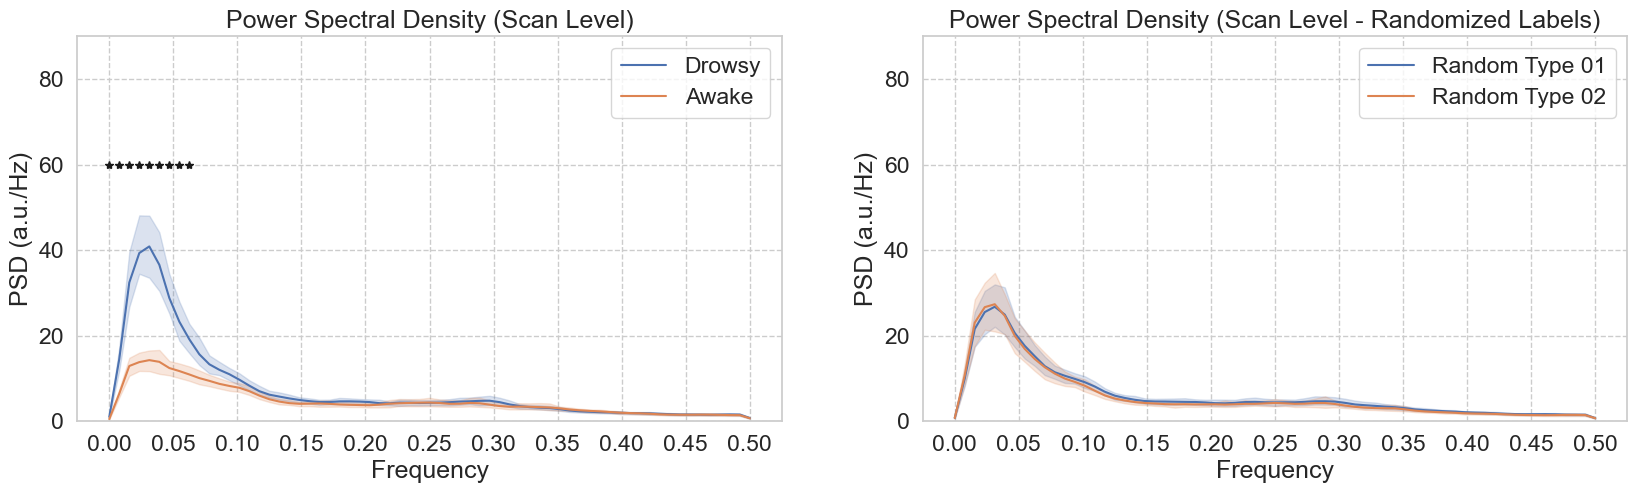

In [17]:
fig

### 6. Save Figures to disk

In [18]:
fig.savefig('./figures/Fig05_PanelA.png')